In [2]:
# Scraping data dari ulasan google maps

from serpapi import GoogleSearch
from urllib.parse import urlsplit, parse_qsl
import json
import pandas as pd

params = {
  "api_key": "d12ad9e8a239f30e500a1c2bb18c5256fa13e5966a17c3d39f66ccfadd830085",                    # API key dari serpAPI
  "engine": "google_maps_reviews",                                                                  # serpAPI search engine
  "hl": "id",                                                                                       # language of the search
  "data_id": "0x2e7a584c3f999547:0xf5f81e9fab2e1dfb"                                                # data id yang terletak di dalam URL Tempat Google Maps:di parameter kueri `data=`
}

search = GoogleSearch(params)


reviews = []

page_num = 0
while True:
    page_num += 1
    results = search.get_dict()
    if "error" in results:
        print(f"Error dari API: {results['error']}")
        break
    print(f"Extracting reviews from {page_num} page.")

    if not "error" in results:
        for result in results.get("reviews", []): # return an empty list [] if no reviews from the place
            reviews.append({
                "page": page_num,
                "name": result.get("user").get("name"),
                "link": result.get("user").get("link"),
                "thumbnail": result.get("user").get("thumbnail"),
                "rating": result.get("rating"),
                "date": result.get("date"),
                "snippet": result.get("snippet"),
                "images": result.get("images"),
                "local_guide": result.get("user").get("local_guide"),
                # other data
            })
    else:
        print(results["error"])
        break
    pagination = results.get("serpapi_pagination", {})

    if pagination and pagination.get("next") and pagination.get("next_page_token"):
        search.params_dict.update(dict(parse_qsl(urlsplit(pagination["next"]).query)))
    else:
        break
    if results.get("serpapi_pagination").get("next") and results.get("serpapi_pagination").get("next_page_token"):
        # split URL in parts as a dict and update search "params" variable to a new page that will be passed to GoogleSearch()
        search.params_dict.update(dict(parse_qsl(urlsplit(results["serpapi_pagination"]["next"]).query)))
        #search.params_dict.update(dict(parse_qsl(urlsplit(results["serpapi_pagination"]["next"]).query)))
        #print(result)
    else:
        break


print(json.dumps(reviews, indent=2, ensure_ascii=False))
df = pd.DataFrame(reviews)
df.to_csv(f"data.csv", index=False)

Extracting reviews from 1 page.
Extracting reviews from 2 page.
Extracting reviews from 3 page.
Extracting reviews from 4 page.
Extracting reviews from 5 page.
Extracting reviews from 6 page.
Extracting reviews from 7 page.
Extracting reviews from 8 page.
Extracting reviews from 9 page.
Extracting reviews from 10 page.
Extracting reviews from 11 page.
Extracting reviews from 12 page.
Extracting reviews from 13 page.
Extracting reviews from 14 page.
Extracting reviews from 15 page.
Extracting reviews from 16 page.
Extracting reviews from 17 page.
Extracting reviews from 18 page.
Extracting reviews from 19 page.
Extracting reviews from 20 page.
Extracting reviews from 21 page.
Extracting reviews from 22 page.
Extracting reviews from 23 page.
Extracting reviews from 24 page.
Extracting reviews from 25 page.
Extracting reviews from 26 page.
Extracting reviews from 27 page.
Extracting reviews from 28 page.
Extracting reviews from 29 page.
Extracting reviews from 30 page.
Extracting reviews 

In [15]:
# Import library yang digunakan

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Baca data

df = pd.read_csv('data.csv')

df.shape

(1018, 9)

In [5]:
# Cek null

df.isnull().sum()

page             0
name             0
link             0
thumbnail        0
rating           0
date             0
snippet          0
images         785
local_guide    206
dtype: int64

In [6]:
# Cek data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   page         1018 non-null   int64  
 1   name         1018 non-null   object 
 2   link         1018 non-null   object 
 3   thumbnail    1018 non-null   object 
 4   rating       1018 non-null   float64
 5   date         1018 non-null   object 
 6   snippet      1018 non-null   object 
 7   images       233 non-null    object 
 8   local_guide  812 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 71.7+ KB


In [19]:
# Clean text

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_snippet'] = df['snippet'].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to C:\Users\H O L
[nltk_data]     A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df.head()

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,clean_snippet
0,1,Sandy Nurdiana,https://www.google.com/maps/contrib/1122917984...,https://lh3.googleusercontent.com/a-/ALV-UjXCX...,4.0,sebulan lalu,Pelayanan di RS Dr. Sardjito cukup memuaskan. ...,['https://lh3.googleusercontent.com/geougc-cs/...,True,pelayanan rs dr sardjito memuaskan dokter pera...
1,1,Devi Riyani,https://www.google.com/maps/contrib/1120315249...,https://lh3.googleusercontent.com/a-/ALV-UjV5b...,5.0,sebulan lalu,"First time MCU disini, pelayanan oke banget, r...",['https://lh3.googleusercontent.com/geougc-cs/...,True,first time mcu pelayanan oke banget ramah n ve...
2,1,Sheila NB,https://www.google.com/maps/contrib/1145912811...,https://lh3.googleusercontent.com/a-/ALV-UjWfj...,5.0,2 minggu lalu,beberapa tahun ini rutin ke Hemato Onkologi An...,['https://lh3.googleusercontent.com/geougc-cs/...,True,rutin hemato onkologi anak full pakai bpjs dr ...
3,1,Ria Nur Windarti,https://www.google.com/maps/contrib/1013786408...,https://lh3.googleusercontent.com/a-/ALV-UjX-d...,5.0,4 bulan lalu,Sudah memasuki bulan kedua menjadi pasien rawa...,['https://lh3.googleusercontent.com/geougc-cs/...,True,memasuki pasien rawat jalan poli anak rsup dr ...
4,1,Muhammad Roziqin,https://www.google.com/maps/contrib/1128608618...,https://lh3.googleusercontent.com/a-/ALV-UjWZj...,4.0,sebulan lalu,"Tempatnya bagus, pelayanan juga baik, lokasi s...",['https://lh3.googleusercontent.com/geougc-cs/...,True,tempatnya bagus pelayanan lokasi memadai dised...


In [20]:
# TF-IDF 

tfidf = TfidfVectorizer(max_features=300)
X_text = tfidf.fit_transform(df['clean_snippet']).toarray()

In [21]:
# Gabungkan dengan rating 

scaler = MinMaxScaler()
rating_scaled = scaler.fit_transform(df[['rating']])
X = pd.DataFrame(X_text)
X['rating'] = rating_scaled

In [22]:
# Ubah tipe data menjadi string

X.columns = X.columns.astype(str)

C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Text(0, 0.5, 'WCSS')

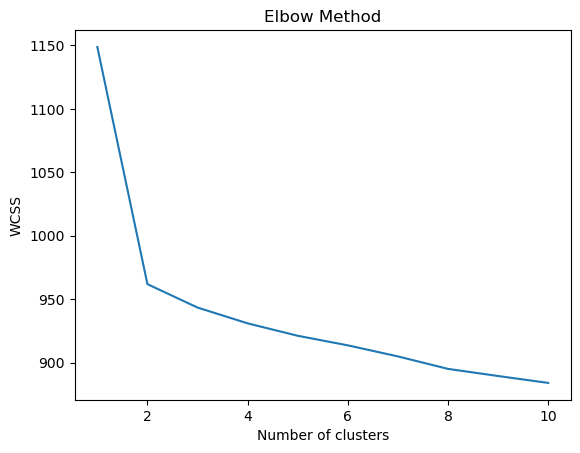

In [23]:
# Cek K(jumlah cluster) dengan Elbow

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Jumlah Klaster = 2, Silhouette Score = 0.1489
Jumlah Klaster = 3, Silhouette Score = 0.0745
Jumlah Klaster = 4, Silhouette Score = 0.0485
Jumlah Klaster = 5, Silhouette Score = 0.0230


C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Jumlah Klaster = 6, Silhouette Score = 0.0224
Jumlah Klaster = 7, Silhouette Score = 0.0234
Jumlah Klaster = 8, Silhouette Score = 0.0252
Jumlah Klaster = 9, Silhouette Score = 0.0246


C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Jumlah Klaster = 10, Silhouette Score = 0.0250


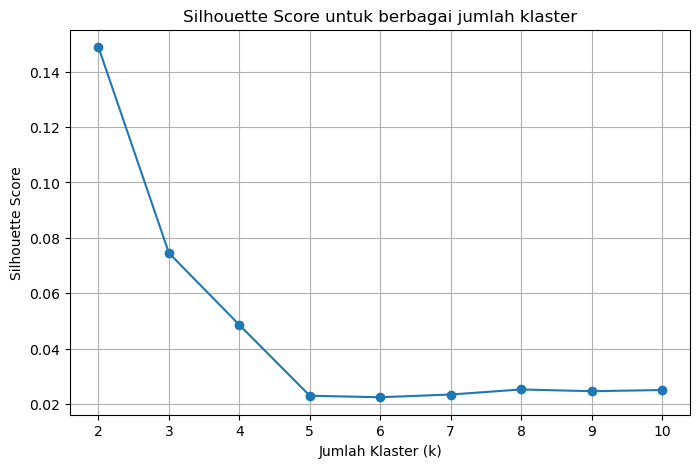

In [24]:
# Cek K(jumlah cluster) dengan silhoutte

scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"Jumlah Klaster = {k}, Silhouette Score = {score:.4f}")
plt.figure(figsize=(8,5))
plt.plot(K, scores, marker='o')
plt.title('Silhouette Score untuk berbagai jumlah klaster')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [25]:
# hitung K-Means dengan K=2

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

C:\Users\H O L A\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


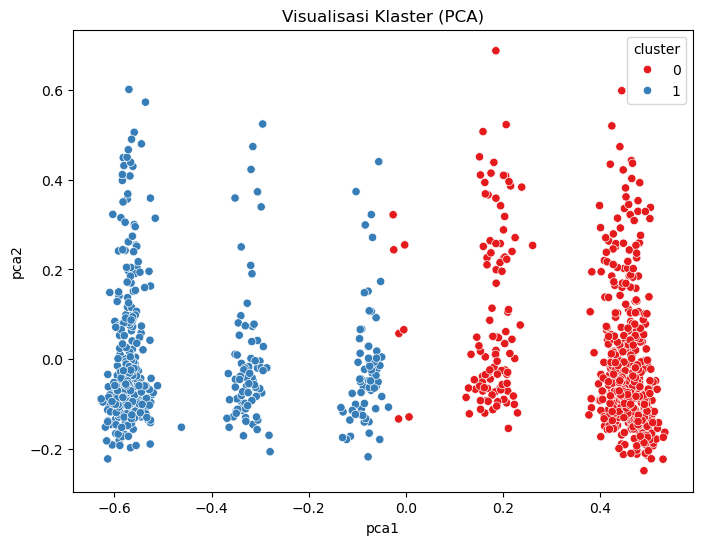

In [26]:
# Visualisasi PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1')
plt.title('Visualisasi Klaster (PCA)')
plt.show()